In [1]:
# Dados de desmatamento às margens do Rio Acre ao longo dos anos - SEXTA


In [16]:
import geopandas as gpd
#Buffer de 10km
# Carregar os dois GeoJSONs como GeoDataFrames
gdf1 = gpd.read_file("buffer5km-rio-acre.geojson")
gdf2 = gpd.read_file("desmatamento_prodes_sirgas2000_19s.geojson")

# Certificar-se de que ambos estão no mesmo sistema de coordenadas
if gdf1.crs != gdf2.crs:
    gdf2 = gdf2.to_crs(gdf1.crs)

# Calcular a interseção entre os dois GeoDataFrames
interseccao = gpd.overlay(gdf1, gdf2, how="intersection")

# Salvar o resultado como um shapefile
interseccao.to_file('5km-rio-acre-desmatamento.geojson', driver='GeoJSON')

In [ ]:
# CARREGAR 3 VISÕES (1KM, 5KM E 10KM) E FAZER ANÁLISES


In [16]:
#ver colunas
print(interseccao.columns)

Index(['nome', 'geometriaa', 'tipotrecho', 'navegavel', 'larguramed', 'regime',
       'encoberto', 'fid', 'state', 'path_row', 'main_class', 'class_name',
       'sub_class', 'def_cloud', 'julian_day', 'image_date', 'year', 'area_km',
       'scene_id', 'source', 'satellite', 'sensor', 'uuid', 'geometry'],
      dtype='object')


In [1]:
# CÁLCULO E ANÁLISES

In [140]:
import geopandas as gpd
import pandas as pd

# Lista de arquivos e buffers
buffers = {
    "1km": "1km-rio-acre-desmatamento.geojson",
    "5km": "5km-rio-acre-desmatamento.geojson",
    "10km": "10km-rio-acre-desmatamento.geojson"
}

# Dicionário para armazenar os resultados
resultados = {}

# Função para realizar análises em cada buffer
for nome_buffer, caminho in buffers.items():
    # Carregar o arquivo de desmatamento
    gdf = gpd.read_file(caminho)
    
    # Certificar-se de que está em um sistema de coordenadas em metros
    if gdf.crs.is_geographic:
        gdf = gdf.to_crs(epsg=31979)  # Exemplo: UTM zona 19S

    # Calcular a área de cada polígono recortado (em m²) e adicionar como nova coluna
    gdf['area_recorte'] = gdf.geometry.area

    # Agrupar por ano e somar as áreas recortadas, já convertendo para km²
    desmatamento_por_ano = gdf.groupby('year')['area_recorte'].sum() / 1000000  # converter para km²

    # 1. Ano com maior desmatamento
    ano_maior_desmatamento = desmatamento_por_ano.idxmax()
    
    # 2. Anos com queda no desmatamento
    queda_desmatamento = desmatamento_por_ano.diff() < 0
    anos_queda = desmatamento_por_ano[queda_desmatamento].index.tolist()
    
    # 3. Maior queda no desmatamento
    maior_queda_ano = desmatamento_por_ano.diff().idxmin()
    
    # 4. Desmatamento total por ano
    desmatamento_total_por_ano = desmatamento_por_ano
    
    # 5. Desmatamento total nos últimos 10 anos
    ultimo_ano = desmatamento_por_ano.index.max()
    desmatamento_ultimos_10_anos = desmatamento_por_ano.loc[ultimo_ano-9:ultimo_ano].sum()
    desmatamento_total = desmatamento_por_ano.sum()
    
    # Armazenar resultados para cada buffer
    resultados[nome_buffer] = {
        "ano_maior_desmatamento": ano_maior_desmatamento,
        "anos_queda": anos_queda,
        "maior_queda_ano": maior_queda_ano,
        "desmatamento_total_por_ano": desmatamento_total_por_ano,
        "desmatamento_ultimos_10_anos_km2": desmatamento_ultimos_10_anos,
        "desmatamento_total_km2": desmatamento_total  # já convertido para km²
    }

# Exibir os resultados
for buffer, dados in resultados.items():
    print(f"Resultados para o buffer de {buffer}:")
    print(dados)
    print("\n")


Resultados para o buffer de 1km:
{'ano_maior_desmatamento': 2021.0, 'anos_queda': [2009.0, 2010.0, 2013.0, 2015.0, 2018.0, 2020.0, 2022.0, 2023.0], 'maior_queda_ano': 2023.0, 'desmatamento_total_por_ano': year
2008.0     7.186493
2009.0     4.887249
2010.0     4.702084
2011.0     7.679606
2012.0    10.320211
2013.0     4.768056
2014.0     7.648708
2015.0     5.178266
2016.0     8.424604
2017.0     9.364377
2018.0     6.270898
2019.0    12.049012
2020.0    11.177088
2021.0    17.400064
2022.0    16.412662
2023.0     7.731505
Name: area_recorte, dtype: float64, 'desmatamento_ultimos_10_anos_km2': 101.65718280649672, 'desmatamento_total_km2': 141.200883113468}


Resultados para o buffer de 5km:
{'ano_maior_desmatamento': 2022.0, 'anos_queda': [2009.0, 2012.0, 2013.0, 2015.0, 2017.0, 2020.0, 2023.0], 'maior_queda_ano': 2023.0, 'desmatamento_total_por_ano': year
2008.0     93.988032
2009.0     47.233767
2010.0     57.614745
2011.0    115.733726
2012.0    108.953523
2013.0     55.772902
2014

In [ ]:
### ANÁLISE DE ÁREAS AO LONGO DO RIO ACRE ###

In [136]:
import geopandas as gpd
from shapely.geometry import LineString, Point, MultiPolygon, Polygon
from shapely.ops import unary_union
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def create_sections(buffer_data, deforestation_data, num_sections=10):
    """
    Cria seções de área igual ao longo do rio
    buffer_data: GeoDataFrame com o buffer do rio original
    deforestation_data: GeoDataFrame com as áreas desmatadas
    """
    # Unir todas as geometrias do buffer
    buffer_geometry = unary_union(list(buffer_data.geometry))
    
    # Calcular a área total do buffer
    total_area = buffer_geometry.area
    target_area = total_area / num_sections
    
    # Obter os limites do rio
    minx, miny, maxx, maxy = buffer_geometry.bounds
    
    sections = []
    colors = plt.cm.tab20(np.linspace(0, 1, num_sections))
    
    current_geometry = buffer_geometry
    for i in range(num_sections):
        if i == num_sections - 1:
            # Última seção
            section_geom = current_geometry
        else:
            # Busca binária para encontrar o ponto de divisão que resulta em área igual
            left = minx
            right = maxx
            best_section = None
            best_diff = float('inf')
            
            for _ in range(10):  # Número de iterações para convergência
                mid = (left + right) / 2
                
                # Criar linha vertical de divisão
                dividing_line = LineString([(mid, miny), (mid, maxy)])
                
                # Dividir a geometria atual
                left_geom = current_geometry.difference(
                    Polygon([
                        (mid, miny), (maxx, miny),
                        (maxx, maxy), (mid, maxy)
                    ])
                )
                
                area_diff = abs(left_geom.area - target_area)
                
                if area_diff < best_diff:
                    best_diff = area_diff
                    best_section = left_geom
                
                if left_geom.area > target_area:
                    right = mid
                else:
                    left = mid
            
            section_geom = best_section
            # Atualizar a geometria restante
            current_geometry = current_geometry.difference(section_geom)
        
        if not section_geom.is_empty:
            # Calcular área desmatada intersectando com as áreas de desmatamento
            section_mask = deforestation_data.intersects(section_geom)
            intersecting_areas = deforestation_data[section_mask]
            deforested_area = sum(
                geom.intersection(section_geom).area 
                for geom in intersecting_areas.geometry
            )
            
            sections.append({
                'geometry': section_geom,
                'section_id': i + 1,
                'total_area': section_geom.area,
                'deforested_area': deforested_area,
                'color': mcolors.rgb2hex(colors[i][:3])
            })
    
    # Criar GeoDataFrame
    sections_gdf = gpd.GeoDataFrame(sections, crs=buffer_data.crs)
    
    # Calcular percentual de desmatamento
    sections_gdf['deforestation_percentage'] = (
        sections_gdf['deforested_area'] / sections_gdf['total_area'] * 100
    ).round(2)
    
    return sections_gdf

def plot_sections(sections_gdf, deforestation_data, title="Seções do Rio"):
    """
    Plota as seções coloridas e adiciona informações sobre desmatamento
    """
    fig, ax = plt.subplots(figsize=(15, 10))
    
    # Plotar cada seção com sua cor
    for idx, row in sections_gdf.iterrows():
        gpd.GeoSeries([row.geometry], crs=sections_gdf.crs).plot(
            ax=ax,
            color=row['color'],
            alpha=0.7,
            label=f'Seção {row["section_id"]}'
        )
    
    # Plotar áreas de desmatamento
    deforestation_data.plot(ax=ax, color='red', alpha=0.3)
    
    # Adicionar rótulos com informações
    for idx, row in sections_gdf.iterrows():
        centroid = row.geometry.centroid
        ax.annotate(
            f'Seção {row["section_id"]}\n'
            #f'Área Total: {row["total_area"]/1000000:.2f} km²\n'
            f'Desmatamento: {row["deforested_area"]/1000000:.2f} km²\n',
            (centroid.x, centroid.y),
            ha='center',
            va='center',
            fontsize=8,
            bbox=dict(facecolor='white', alpha=0.7)
        )
    
    # Configurar o plot
    ax.set_title(title)
    ax.axis('equal')
    plt.axis('off')
    
    # Adicionar legenda
    ax.legend(title="Seções do Rio", 
             bbox_to_anchor=(1.05, 1), 
             loc='upper left')
    
    # Ajustar o layout
    plt.tight_layout()
    
    return fig, ax

def analyze_and_plot_river(buffer_file, deforestation_file, output_file, num_sections=10):
    """
    Função principal que analisa o rio e gera a visualização
    """
    # Carregar dados
    buffer_data = gpd.read_file(buffer_file)
    deforestation_data = gpd.read_file(deforestation_file)
    
    # Criar seções
    sections = create_sections(buffer_data, deforestation_data, num_sections)
    
    # Salvar resultados
    sections.to_file(output_file, driver='GeoJSON')
    
    # Criar visualização
    fig, ax = plot_sections(sections, deforestation_data)
    
    # Mostrar resumo
    print("\nResumo das seções:")
    print("\nÁreas em km²:")
    summary = sections[['section_id', 'total_area', 'deforested_area', 'deforestation_percentage']]
    summary['total_area_km2'] = summary['total_area'] / 1000000
    summary['deforested_area_km2'] = summary['deforested_area'] / 1000000
    print(summary[['section_id', 'deforested_area_km2']].round(2))
    
    return sections, fig, ax

/tmp/ipykernel_24035/1065837730.py:133: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(title="Seções do Rio",
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_24035/1065837730.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary['total_area_km2'] = summary['total_area'] / 1000000



Resumo das seções:

Áreas em km²:
   section_id  deforested_area_km2
0           1                 0.00
1           2                 3.60
2           3                 8.45
3           4                 9.49
4           5                22.12
5           6                40.57
6           7                17.90
7           8                13.58
8           9                18.06
9          10                 7.44


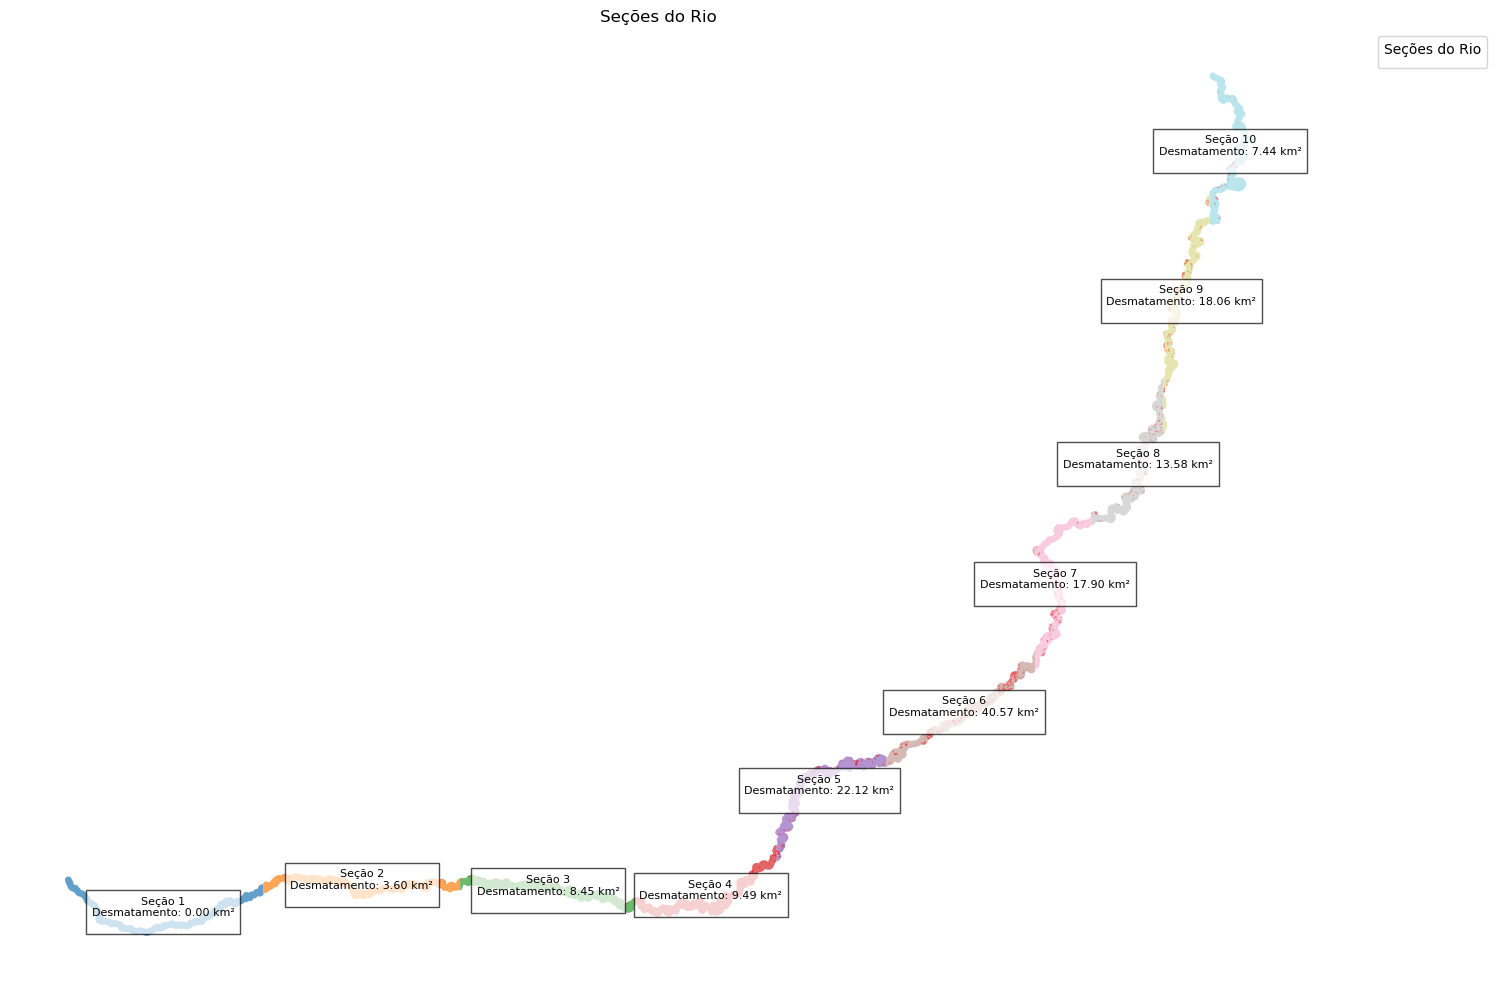

In [138]:
# Analisar, plotar e salvar
sections, fig, ax = analyze_and_plot_river(
    "buffer1km-rio-acre.geojson",  # arquivo com o buffer original do rio
    "1km-rio-acre-desmatamento.geojson",  # arquivo com as áreas desmatadas
    "secoes_rio-1km.geojson"
)

# Mostrar o plot
plt.show()